In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

# 데이터셋 생성

In [15]:
import os

X = np.empty((2000, 64, 64, 3))
Y = np.empty((2000,))

target = 'Bicycle'

folders = os.listdir('./images')
folders.remove(target)
folders.remove('Other')

files = os.listdir(f'./images/{target}')
for i in range(1000):
    x = cv2.imread(f"./images/{target}/{files[i]}")
    X[i] = cv2.resize(x, (64, 64))
    Y[i] = 1

files = os.listdir('./images/Other')
for i in range(300):
    x = cv2.imread(f"./images/Other/{files[i]}")
    X[i+1000] = cv2.resize(x, (64, 64))
    Y[i+1000] = 0

for f in range(7):
    files = os.listdir(f'./images/{folders[f]}')
    for i in range(100):
        x = cv2.imread(f"./images/{folders[f]}/{files[i]}")
        X[1300+f*100+i] = cv2.resize(x, (64, 64))
        Y[1300+f*100+i] = 0

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0)

In [17]:
print(X_train.shape)
print(X_test.shape)
print( y_train.shape)
print(y_test.shape)

(1500, 64, 64, 3)
(500, 64, 64, 3)
(1500,)
(500,)


# 모델 생성

In [18]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(256, (3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(1024, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [19]:
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=[
        'accuracy',
    ],
)

In [20]:
modelpath=f"./history/{target.lower()}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

In [21]:
history = model.fit(X_train, y_train, validation_split=0.25, epochs=30, batch_size=100, verbose='auto', callbacks=[early_stopping_callback,checkpointer])

Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 3.2152 - accuracy: 0.5236
Epoch 1: val_loss improved from inf to 0.68965, saving model to ./history\bicycle.hdf5
12/12 [==============================] - 15s 862ms/step - loss: 3.2152 - accuracy: 0.5236 - val_loss: 0.6897 - val_accuracy: 0.5360
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 0.7229 - accuracy: 0.4409
Epoch 2: val_loss did not improve from 0.68965
12/12 [==============================] - 11s 897ms/step - loss: 0.7229 - accuracy: 0.4409 - val_loss: 0.6924 - val_accuracy: 0.5253
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 0.6959 - accuracy: 0.4933
Epoch 3: val_loss did not improve from 0.68965
12/12 [==============================] - 10s 844ms/step - loss: 0.6959 - accuracy: 0.4933 - val_loss: 0.6918 - val_accuracy: 0.5973
Epoch 4/30
12/12 [==============================] - ETA: 0s - loss: 0.6928 - accuracy: 0.5138
Epoch 4: val_loss improved from 0.68965 to 0.68

In [22]:
model.evaluate(X_train, y_train)
model.evaluate(X_test, y_test)

16/16 [==============================] - 1s 53ms/step - loss: 0.5262 - accuracy: 0.8320


[0.5261737108230591, 0.8320000171661377]

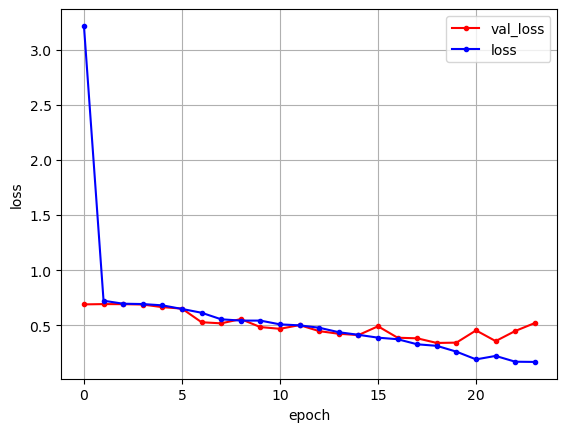

In [23]:
val_loss = history.history['val_loss']
loss = history.history['loss']

x_len = np.arange(len(loss))
plt.plot(x_len, val_loss, marker='.', c="red", label='val_loss')
plt.plot(x_len, loss, marker='.', c="blue", label='loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

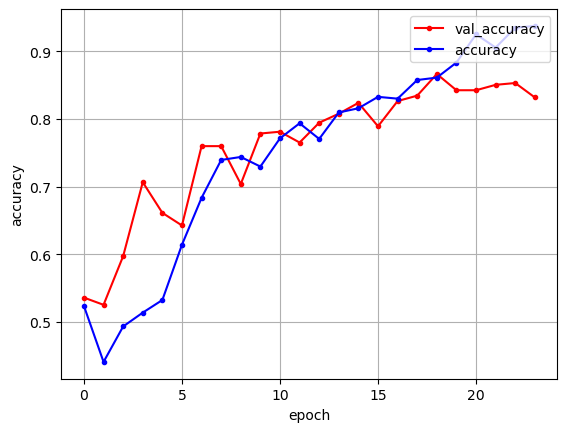

In [24]:
val_accuracy = history.history['val_accuracy']
accuracy = history.history['accuracy']

x_len = np.arange(len(accuracy))
plt.plot(x_len, val_accuracy, marker='.', c="red", label='val_accuracy')
plt.plot(x_len, accuracy, marker='.', c="blue", label='accuracy')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [25]:
model.save(f"./models/{target.lower()}.hdf5")